# BL40A2020 Wireless Communication Systems

## Week 5: Optimal demodulation

## Author: Pedro Nardelli


In [1]:
#! pip install scikit-dsp-comm

In [37]:
! pip install komm

In [38]:
import math
import komm
import sympy as sp
from sympy.stats import Normal, density, E, std, cdf
sp.init_printing() 
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
import warnings
warnings.filterwarnings('ignore')
import ipywidgets

# Binary symmetric channel

![](https://upload.wikimedia.org/wikipedia/commons/b/b5/Binary_symmetric_channel.svg)

Let's consider the following.

- Pr[transmit 0] = $q$
- Pr[transmit 1] = $1-q$
- Pr[receive 0 | transmit 0] = $1-p$
- Pr[receive 0 | transmit 1] = $p$
- Pr[receive 1 | transmit 1] = $1-p$
- Pr[receive 1 | transmit 0] = $p$

Probability theory states the following relations:

## Law of total probability
### Pr[receive 0] = Pr[receive 0 | transmit 0] x Pr[transmit 0] + Pr[receive 0 | transmit 1] x Pr[transmit 1] = $p + q - 2pq$
### Pr[receive 1] = Pr[receive 1 | transmit 0] x Pr[transmit 0] + Pr[receive 1 | transmit 1] x Pr[transmit 1] = $1 - (p + q - 2pq)$

## Bayes
### Pr[transmit X | receive Y] x Pr[receive Y] = Pr[receive Y | transmit X] x Pr[transmit X]


## Experiment 

In [39]:
input_seq_size = 100 # sequence
tp = np.arange(0, input_seq_size , 1)
p_aux = 0.7 # q 
input_seq = np.random.choice([0, 1], size=input_seq_size, p=[p_aux, 1-p_aux])
p =0.1
bsc = komm.BinarySymmetricChannel(p)
output_seq = bsc(input_seq)
p_r0 = (1-p)*p_aux + p*(1-p_aux)
p_t0_r0 = (1-p)*p_aux/p_r0
p_t1_r1 = (1-p)*(1-p_aux)/(1-p_r0)
num_zeros = (input_seq == 0).sum()
num_ones = (input_seq == 1).sum()
num_zeros_bsc = (output_seq== 0).sum()
num_ones_bsc = (output_seq == 1).sum()
print("Simulation vs. analytical results")
print("#################")
print("Input")
print("Probability input 0", num_zeros/input_seq_size, "Analytical:", p_aux)
print("Probability input 1:", num_ones/input_seq_size, "Analytical:", 1 - p_aux)
print("#################")
print("Output")
print("Probability output 0:", num_zeros_bsc/input_seq_size, "Analytical:", p_r0)
print("Probability output 1:",num_ones_bsc/input_seq_size, "Analytical:", 1 - p_r0)
print("#################")
print("Error probability due to channel")
count_0_1 = 0
count_1_0 = 0
for i in range(input_seq_size):
    if input_seq[i] != output_seq[i]:
        if input_seq[i] == 0:
            count_0_1 = count_0_1 +1
        if input_seq[i] == 1:
            count_1_0 = count_1_0 +1
print("Probability output 0 given input 1:",count_0_1/num_zeros, "Analytical:", p)
print("Probability output 1 given input 0:",count_1_0/num_ones, "Analytical:", p)
count_out0_in1 = 0
count_out1_in0  = 0
for i in range(input_seq_size):
    if output_seq[i] == 0:
        if input_seq[i] == 1:        
            count_out0_in1 = count_out0_in1 + 1
    if output_seq[i] == 1:
        if input_seq[i] == 0: 
            count_out1_in0 = count_out1_in0  + 1            
print("#################")
print("Conditional probabilities")   
print("Probability for input 0")   
print("Probability input 0 given output 0:",1 - count_out0_in1/num_zeros_bsc, "Analytical:", p_t0_r0)
print("Probability input 1 given output 0:",count_out0_in1/num_zeros_bsc, "Analytical:", 1 - p_t0_r0)            
print("Probability for input 1")            
print("Probability input 1 given output 1:", 1 - count_out1_in0 /num_ones_bsc, "Analytical:", p_t1_r1)
print("Probability input 0 given output 1:", count_out1_in0 /num_ones_bsc, "Analytical:", 1 - p_t1_r1)

Simulation vs. analytical results
#################
Input
Probability input 0 0.73 Analytical: 0.7
Probability input 1: 0.27 Analytical: 0.30000000000000004
#################
Output
Probability output 0: 0.7 Analytical: 0.66
Probability output 1: 0.3 Analytical: 0.33999999999999997
#################
Error probability due to channel
Probability output 0 given input 1: 0.0684931506849315 Analytical: 0.1
Probability output 1 given input 0: 0.07407407407407407 Analytical: 0.1
#################
Conditional probabilities
Probability for input 0
Probability input 0 given output 0: 0.9714285714285714 Analytical: 0.9545454545454545
Probability input 1 given output 0: 0.02857142857142857 Analytical: 0.045454545454545525
Probability for input 1
Probability input 1 given output 1: 0.8333333333333334 Analytical: 0.7941176470588238
Probability input 0 given output 1: 0.16666666666666666 Analytical: 0.20588235294117618


## Error probability

### Rule n.1

- If p < 0.5 -> Transmitted = Received 
- If p > 0.5 -> Transmitted ≠ Received
- If p = 0.5 -> “Fair coin” selection

Error probability is equal to the channel error $$P_\mathrm{e} = p,$$ with maximum value is $P_\mathrm{e} = 0.5$ regardless of $q$.

### Rule n.2: Maximize Pr[transmit X | receive Y] = Pr[receive Y | transmit X] x Pr[transmit X]/Pr[receive Y] 

*If 0 is received, choose the 0 or 1 that has greater value*
- Pr[transmit 0 | receive 0] = $$\dfrac{(1-p)q}{p+q-2pq}$$
- Pr[transmit 1 | receive 0] = $$\dfrac{p(1-q)}{p+q-2pq}$$

*If 1 is received, choose the 0 or 1 that has greater value*
- Pr[transmit 0 | receive 1] = $$\dfrac{pq}{1-(p+q-2pq)}$$
- Pr[transmit 1 | receive 1] = $$\dfrac{(1-p)(1-q)}{1-(p+q-2pq)}$$

*Decisions*

- If 0 is received: choose 0 if $p<q$, or choose 1 if $p>q$
- If 1 is received: choose 0 if $pq>(1-p)(1-q)$, or choose 1 if $pq<(1-p)(1-q)$

The error probability is then: $$P_\mathrm{e} = \min((1-p),p,q,(1-q))$$.

In [40]:
#For the case studied before
p=0.1
#q=p_aux 
q=0.7

print("Receive 0")
print("p=", p)
print("q=",q)
print("Receive 1")
print("p*q=",p*q)
print("(1-p)*(1-q)=",(1-p)*(1-q))
print("Error probability:",min(p,q,(1-p),(1-q)))

Receive 0
p= 0.1
q= 0.7
Receive 1
p*q= 0.06999999999999999
(1-p)*(1-q)= 0.2700000000000001
Error probability: 0.1


**Therefore:** Select 0 if received is 0, and 1 if received is 1. 
Error probability is $p$

### Other example

In [41]:
#For the case studied before
p=0.3
#q=p_aux 
q=0.8

print("Receive 0")
print("p=", p)
print("q=",q)
print("Receive 1")
print("p*q=",p*q)
print("(1-p)*(1-q)=",(1-p)*(1-q))

Receive 0
p= 0.3
q= 0.8
Receive 1
p*q= 0.24
(1-p)*(1-q)= 0.13999999999999996


**Therefore:** Always select 0, and an error event will always happen when 1 is transmitted. The error probability is then $1-q$.

# Error probability in noisy channel in digital communications

## Example: Binary on-off keying in Gaussian noise (Ex. 5.6.3)

### Transmission

- Transmitted signal: $m$ if input bit is 1, $0$ if the input bit is 0.
- Noise channel: independent and identically distributed (i.i.d.) Gaussian random variable so that $N \sim \mathcal{N}(0,\nu^2)$
- If 0 and 1 are equally distributed, signal power is $0.5 \cdot m^2 + 0.5 \cdot 0 = m^2/2$

### Reception

- Received signal: $Y = m + N$ if input bit is 1, or $Y = N$ is output bit is 0.
- Noise power: $E[N] = \nu^2$
- Signal to noise ratio (SNR): $\mathrm{SNR} = m^2/(2\nu^2)$

### Decision

- If $Y > m/2$, then 1
- If $Y \leq m/2$, then 0

### Error probabilities

Let's see first how the received signal looks like.

In [42]:
input_rate = 100
input_seq_size = 20
tp = np.arange(0, input_seq_size , 1)/input_rate # time / period = 1 bit per period
input_seq = np.random.randint(2, size=input_seq_size)
print("Input sequence:", input_seq)
print("Length:", len(input_seq))

Input sequence: [0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0]
Length: 20


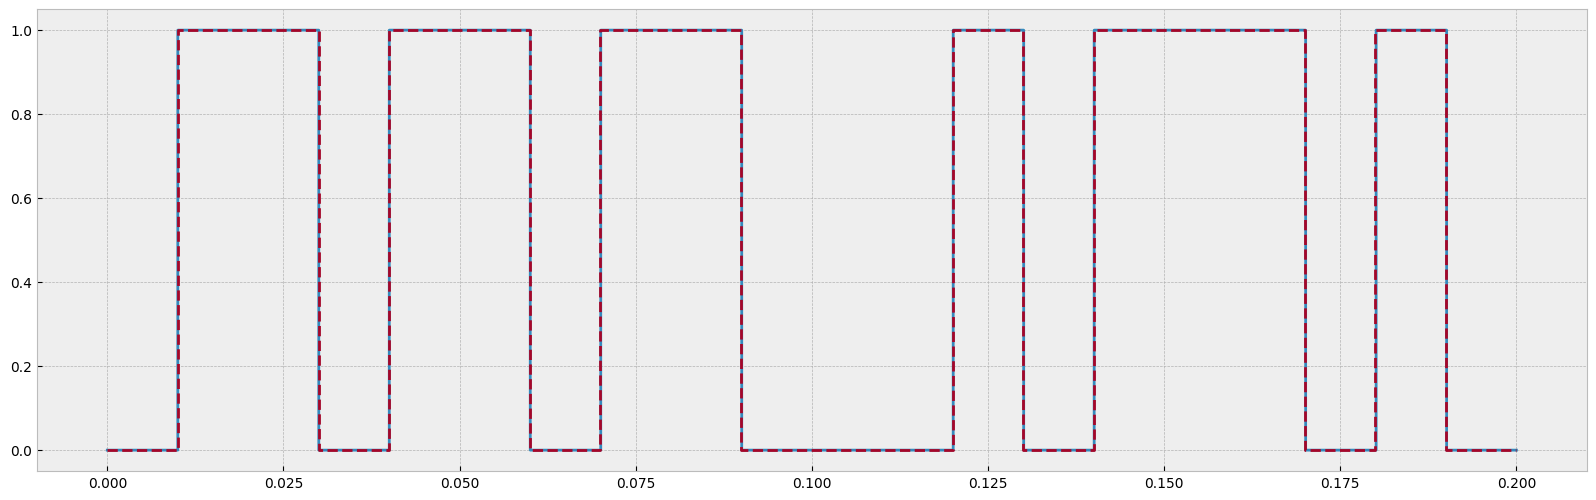

In [43]:
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/input_rate)
#How many point will be evaluated to plot the wave form curve - ns times the input sequence length
n_samples = 100
tmod_points = n_samples*input_seq_size
#Creating this array with these points
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
#To calculate t, it is needed to build a new array with this granularity.
wave_aux = input_seq
input_wave = np.zeros(tmod_points)
##################################
for i in range(0, tmod_points):
    aux = math.floor(i/n_samples)
    if wave_aux[aux] == 0: 
        input_wave[i] = wave_aux[aux]
    if wave_aux[aux] == 1:
        input_wave[i] = wave_aux[aux] 
plt.rcParams['figure.figsize'] = 20, 6
plt.step(tmod,input_wave,where='post')
plt.step(tp_plot,input_seq_plot,linestyle='--',where='post')
plt.show()

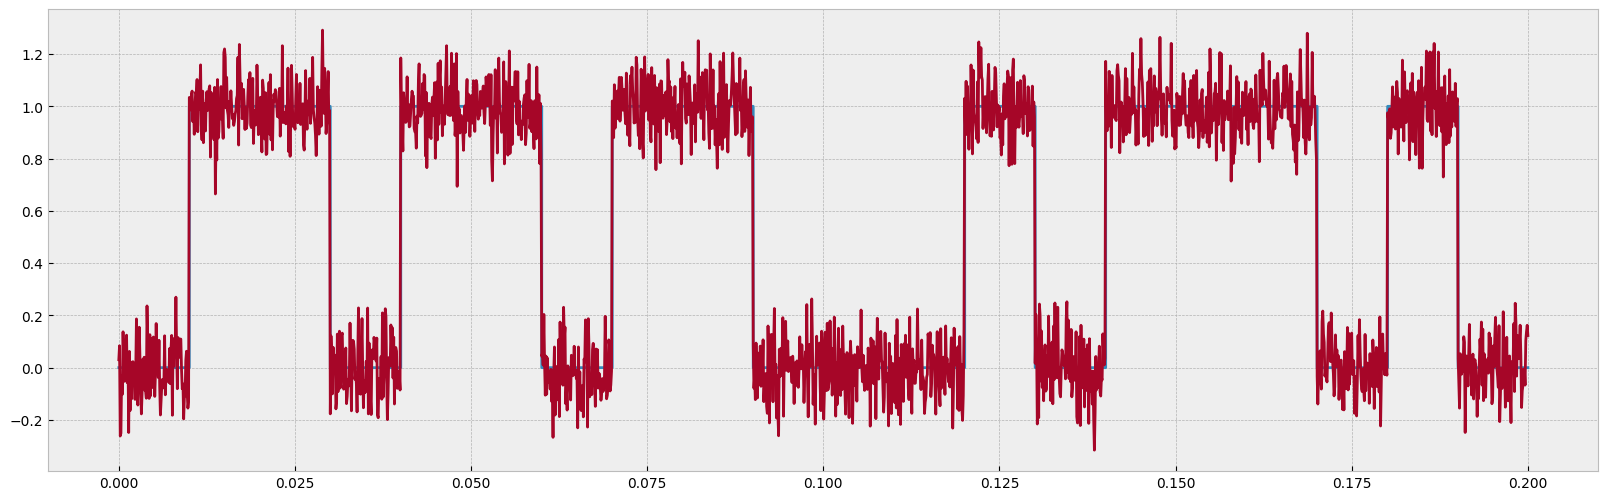

In [44]:
mu, sigma = 0, 0.1 # mean and standard deviation
noise = np.random.normal(mu, sigma, tmod_points)
plt.step(tmod,input_wave,where='post')
plt.plot(tmod,input_wave + noise)

### How to decide?

Simplest case, only one sample from the noise signal.

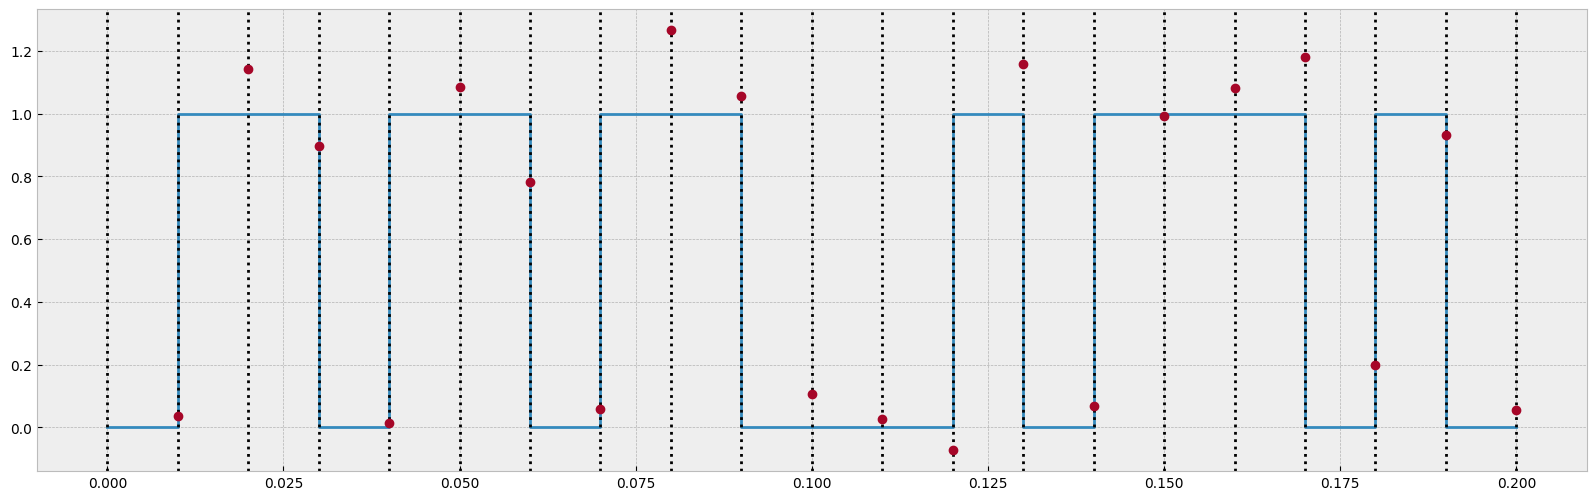

In [45]:
mu, sigma = 0, 0.1 # mean and standard deviation
noise2 = np.random.normal(mu, sigma, input_seq_size)
plt.step(tp_plot,input_seq_plot,where='post');
for i in range(input_seq_size + 1):
    plt.axvline(i/n_samples,linestyle=':',color='k');
plt.plot(tp + 1/input_rate, input_seq + noise2,'o');

In [46]:
m = sp.Symbol("m")
nu = sp.Symbol("nu", positive=True)
y = sp.Symbol("y")

In [47]:
Y_t1 = sp.stats.Normal("x", m, nu)
Y_t0 = sp.stats.Normal("x", 0, nu)

#### For a general Gaussian RV: $\mathrm{Pr}[X \leq m + \alpha \nu] = \mathrm{Pr}[(X - m) /\nu > \alpha] = Q(\alpha)$, where $\alpha$ is the number of standard deviations away from the mean.

The [$Q$-function](https://en.wikipedia.org/wiki/Q-function) can be defined in terms of the error function as follows.

In [48]:
def Q(x):
    return sp.simplify(1/2 * sp.erfc(x/sp.sqrt(2)))

In [49]:
Q(y)

#### Pr[receive 0 | transmit 1] = $\mathrm{Pr}[Y \leq m/2 \;|\; y = m + N]$ 

In [50]:
er1 = sp.simplify(sp.stats.cdf(Y_t1)(m/2))
er1.rewrite(sp.erfc)

Is it possible to write in terms of $Q$-function?

In [51]:
Q(m/(2*nu))

#### Pr[receive 1 | transmit 0] = $\mathrm{Pr}[Y > m/2 \;|\; y = N]$

In [52]:
er0 = 1- sp.simplify(sp.stats.cdf(Y_t0)(m/2))
er0.rewrite(sp.erfc)

In [53]:
Q(m/(2*nu))

#### Error probability

In [54]:
er = er1 * 0.5 + er0 * 0.5
er.rewrite(sp.erfc)

In [55]:
Q(m/(2*nu))

Note that $\dfrac{m}{2 \nu} = \sqrt{\dfrac{\mathrm{SNR}}{2}}$.

#### If the SNR is 13 dB, which means $13 = 10 \log_{10} \mathrm{SNR} \Rightarrow \mathrm{SNR} = 10^{1.3} \approx 20$. The error probability is then:

In [56]:
sp.N(Q(sp.sqrt(10**1.3 / 2)))

We can plot to see the performance of the system in terms of error probability as a function of the SNR in dB.

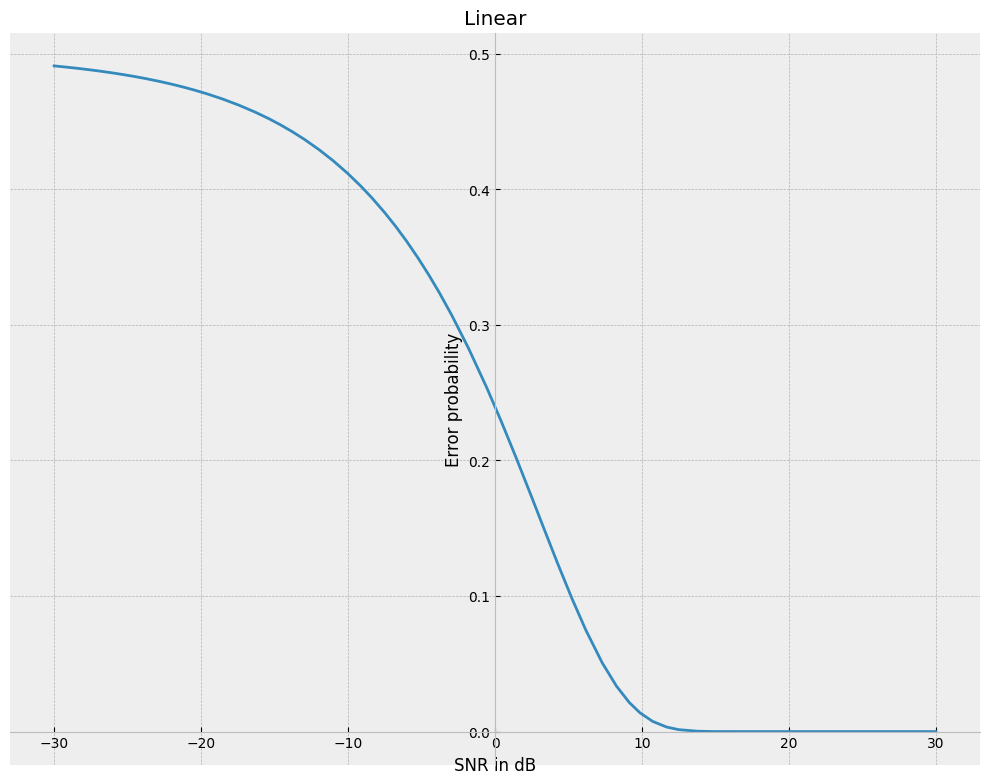

In [57]:
plt.rcParams['figure.figsize'] = 10, 8
sp.plot(sp.N(Q(sp.sqrt(10**(y/10) / 2))),(y,-30,30),xlabel='SNR in dB',ylabel='Error probability', title='Linear');

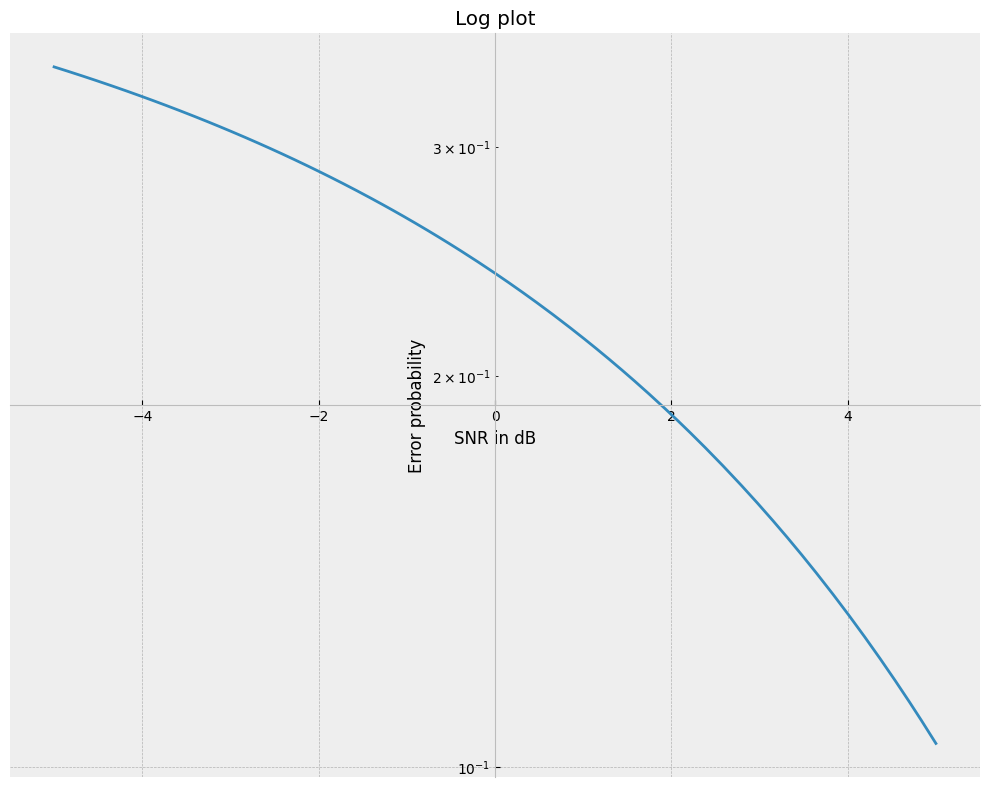

In [58]:
sp.plot(sp.N(Q(sp.sqrt(10**(y/10) / 2))),(y,-5,5),xlabel='SNR in dB',ylabel='Error probability',
        yscale= 'log', title='Log plot');

## Is this decision rule the optimal one?

- Decision rule = *guessing strategy from the observation*.
- Optimality is based on the conditional probability distribution

### Maximum likelihood (ML): 

- Pick the event $i$ that maximize the conditional probability $p(y \mid i)$
- For example, if 0 is observed, and it is known that Pr[receive 0 | transmit 0] > Pr[receive 0 | transmit 1], then the choice is that 0 was transmitted.
- But, how about the *prior* distributions? If there is much more 1's being transmitted than 0's. Would this make a difference?


### Maximum a posteriori (MAP):

- Pick the hypothesis $H_i$ that is more likely conditioned on the value of the observation $Y=y$. 

- For example, if 0 is observed, we need to consider bot only Pr[receive 0 | transmit 0] and Pr[receive 0 | transmit 1], but also Pr[transmit 0] and  Pr[transmit 1] (the *prior* probabilities). 

- From Bayes, we can generalize: $\mathrm{Pr}[H_i \mid Y=y] = \dfrac{p(y \mid i) \cdot \mathrm{Pr}[H_i]}{p(y)}$,
where $\mathrm{Pr}[H_i] = \pi_i = $ Pr[transmit $i$].

#### Therefore:

- **MAP minimizes error probability**
- **MAP reduces to ML if the distribution of input events are uniform.**

### Let's go back to the previous case, to see the differences in the error probability plot.

- $\mathrm{Pr}[H_0] = \pi_0 = p$ 
- $\mathrm{Pr}[H_i] = \pi_i = 1- p$ 

#### For ML:

- $p(y \mid 0) > p(y \mid 1) \Rightarrow H_0$
- $p(y \mid 0) < p(y \mid 1) \Rightarrow H_1$

Then, from eq. (6.13)

- $Y < \dfrac{m}{2} \Rightarrow H_0$


- $Y > \dfrac{m}{2} \Rightarrow H_1$

We will rewrite the error equation from before, but now considering the different prior probabilities.

In [59]:
p = sp.Symbol("p")
SNR = sp.Symbol("SNR")
db= sp.Symbol("SNR_{dB}")


# 
er_ML = er1 * (1-p) + er0 * p
sp.simplify(er_ML).rewrite(sp.erfc)
er_ML_SNR = er_ML.subs(m, sp.sqrt(2*nu**2*SNR)).subs(nu,1)
er_ML_dB = er_ML_SNR.subs(SNR, 10**(db/10))

It is basically the same as before, which is expected since it should be independent of the prior probabilities.

#### For MAP:

- $p(y \mid 0) \cdot p > p(y \mid 1) \cdot(1-p)  \Rightarrow H_0$
- $p(y \mid 0) \cdot p  < p(y \mid 1) \cdot(1-p)  \Rightarrow H_1$

We need to find the new threshold value for MAP by solving the equation: $p(y \mid 0) \cdot p = p(y \mid 1) \cdot(1-p) $. From eq. (6.14), we have: 

- $Y < \dfrac{m}{2} + \dfrac{\nu^2}{m} \log\left(\dfrac{p}{1-p} \right) \Rightarrow H_0$


- $Y > \dfrac{m}{2} + \dfrac{\nu^2}{m} \log\left(\dfrac{p}{1-p} \right) \Rightarrow H_1$


#### Error events:

- Pr[guess 0 | transmit 1] = $\mathrm{Pr}\left[Y \leq \dfrac{m}{2} + \dfrac{\nu^2}{m} \log\left(\dfrac{p}{1-p} \right) \;\Big\lvert \; y = m + N \right]$ 


- Pr[guess 1 | transmit 0] = $\mathrm{Pr}\left[Y > \dfrac{m}{2} + \dfrac{\nu^2}{m} \log\left(\dfrac{p}{1-p} \right) \;\Big\lvert \; y = N \right]$ 

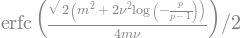

In [60]:
er0_MAP = 1- sp.simplify(sp.stats.cdf(Y_t0)(m/2 + nu**2/m * sp.log(p/(1-p))))
er0_MAP.rewrite(sp.erfc)

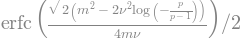

In [61]:
er1_MAP = sp.simplify(sp.stats.cdf(Y_t1)(m/2 + nu**2/m * sp.log(p/(1-p))))
er1_MAP.rewrite(sp.erfc)

In [62]:
er_MAP = (er1_MAP * (1-p) + er0_MAP * p).rewrite(sp.erfc)
er_MAP_SNR = er_MAP.subs(m, sp.sqrt(2*nu**2*SNR)).subs(nu,1)
er_MAP_dB = er_MAP_SNR.subs(SNR, 10**(db/10))

#### Evaluate the performance of ML and MAP as a function of SNR for an arbitrary $p$

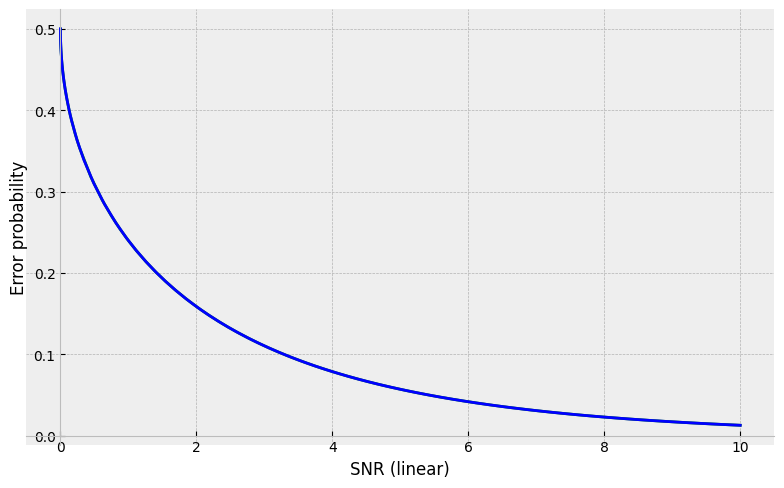

In [63]:
p0=0.5
plt.rcParams['figure.figsize'] = 8, 5
plot_aux = sp.plot(sp.N(er_ML_SNR.subs(p,p0)),sp.N(er_MAP_SNR.subs(p,p0)),(SNR,0,10),xlabel='SNR (linear)',ylabel='Error probability', show=False);
plot_aux[0].line_color = 'g'
plot_aux[1].line_color = 'b'
plot_aux.show()


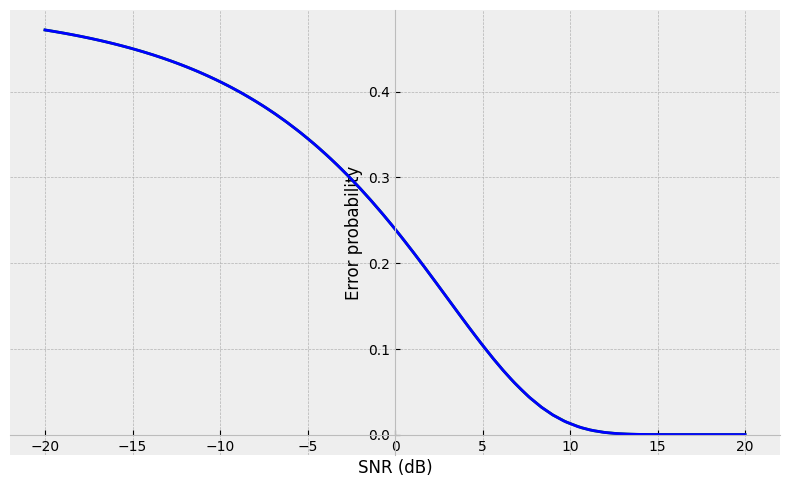

In [64]:
plot_aux = sp.plot(sp.N(er_ML_dB.subs(p,p0)),sp.N(er_MAP_dB.subs(p,p0)), (db,-20,20), xlabel='SNR (dB)', 
                   ylabel='Error probability', show=False);
plot_aux[0].line_color = 'g'
plot_aux[1].line_color = 'b'
plot_aux.show()

## Digital modulation: $M$-QAM

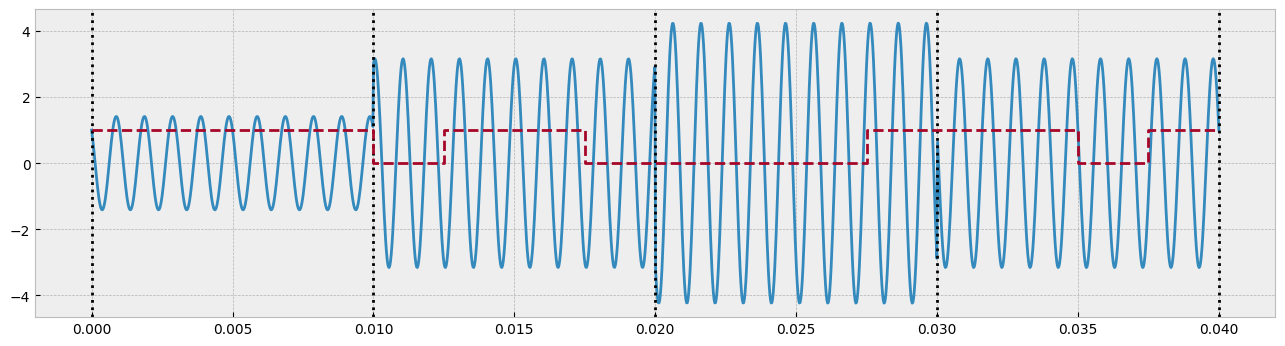

In [65]:
M=16
qam = komm.QAModulation(M)
#
observations = int
observations = 4 # number sequences of 3 bits
rate = 400
input_seq_size = observations * np.log2(M).astype(int)
time_of_obs = input_seq_size/rate
tp = np.arange(0, input_seq_size, 1)/rate 
input_seq = np.random.randint(2, size=input_seq_size)
input_seq_plot = np.append(input_seq,input_seq[input_seq_size-1])
tp_plot = np.append(tp,tp[input_seq_size-1]+1/rate)
##
n_samples = 100
tmod_points = n_samples*input_seq_size
#
tmod = np.linspace(0, tp_plot[input_seq_size], tmod_points)
#
input_wave_aux = qam.modulate(input_seq)
input_wave_I = np.zeros(tmod_points)
input_wave_Q = np.zeros(tmod_points)
##################################
for i in range(0,tmod_points):
    a = math.floor(i/(n_samples*np.log2(M)))
    for j in range(M):
        if np.around(input_wave_aux[a],decimals=3) == np.around(qam.constellation[j],decimals=3): 
            input_wave_I[i] = qam.constellation[j].real 
            input_wave_Q[i] = qam.constellation[j].imag
###
t,fc = sp.symbols('t,f_c')
uc = sp.cos(2*sp.pi*fc*t)
us = sp.sin(2*sp.pi*fc*t)
freq_c = 1000
modulation_I = sp.lambdify(t,uc.subs(fc,freq_c),"numpy")
modulation_Q = sp.lambdify(t,us.subs(fc,freq_c),"numpy")
###
plt.rcParams['figure.figsize'] = 16, 4
plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod))
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')

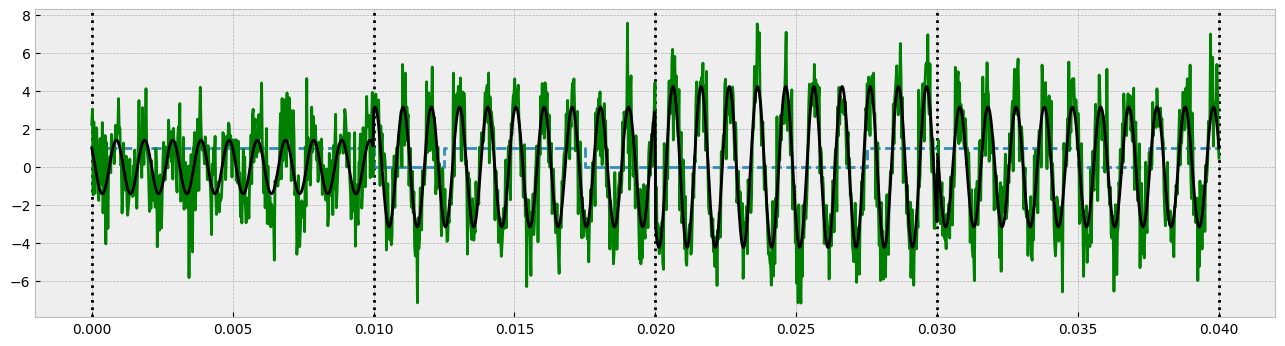

In [66]:
###
t,fc = sp.symbols('t,f_c')
uc = sp.cos(2*sp.pi*fc*t)
us = sp.sin(2*sp.pi*fc*t)
freq_c = 1000
modulation_I = sp.lambdify(t,uc.subs(fc,freq_c),"numpy")
modulation_Q = sp.lambdify(t,us.subs(fc,freq_c),"numpy")
###
plt.rcParams['figure.figsize'] = 16, 4
for i in range(observations + 1):
    plt.axvline(i*np.log2(M)/rate,linestyle=':',color='k');
plt.step(tp_plot ,input_seq_plot,where='post',linestyle='--')

mu, sigma = 0, 1 # mean and standard deviation
noiseQ = np.random.normal(mu, sigma, tmod_points)
noiseI = np.random.normal(mu, sigma, tmod_points)
plt.plot(tmod,(input_wave_I*modulation_I(tmod) + noiseI) - (input_wave_Q*modulation_Q(tmod) + noiseQ),'g')


plt.plot(tmod,input_wave_I*modulation_I(tmod) - input_wave_Q*modulation_Q(tmod),'k')
plt.show()

## Moving from the signal to the constellation using correlators and filtering

## How this looks like?

In [67]:
def constellation_demo(modulation, noise_power_db, xlim, ylim):
    awgn = komm.AWGNChannel()

    num_symbols = 10000
    noise_power = 10**(noise_power_db / 10)
    awgn.signal_power = modulation.energy_per_symbol
    awgn.snr = awgn.signal_power / noise_power
    num_bits = modulation.bits_per_symbol * num_symbols
    bits = np.random.randint(2, size=num_bits)
    sentword = modulation.modulate(bits)
    recvword = awgn(sentword)

    _, ax = plt.subplots(figsize=(16, 10))
    ax.scatter(recvword.real, recvword.imag, color='xkcd:light blue', s=1)
    ax.scatter(modulation.constellation.real, modulation.constellation.imag, color='xkcd:blue', s=8**2)
    for (i, point) in enumerate(modulation.constellation):
        binary_label = ''.join(str(b) for b in komm.int2binlist(modulation.labeling[i], width=modulation.bits_per_symbol))
        ax.text(point.real, point.imag + 0.075 * xlim[0], binary_label, horizontalalignment='center')
    ax.set_title(repr(modulation))
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')
    ax.axis('square')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(color='r', linestyle='--', linewidth=1)
    info_text = 'SNR = {:.1f} dB\n'.format(10*np.log10(awgn.snr))
    info_text += 'Eb/N0 = {:.1f} dB'.format(10*np.log10(awgn.snr / modulation.bits_per_symbol))
    ax.text(1.125 * xlim[1], 0.0, info_text, horizontalalignment='left', verticalalignment='center')
    plt.show()

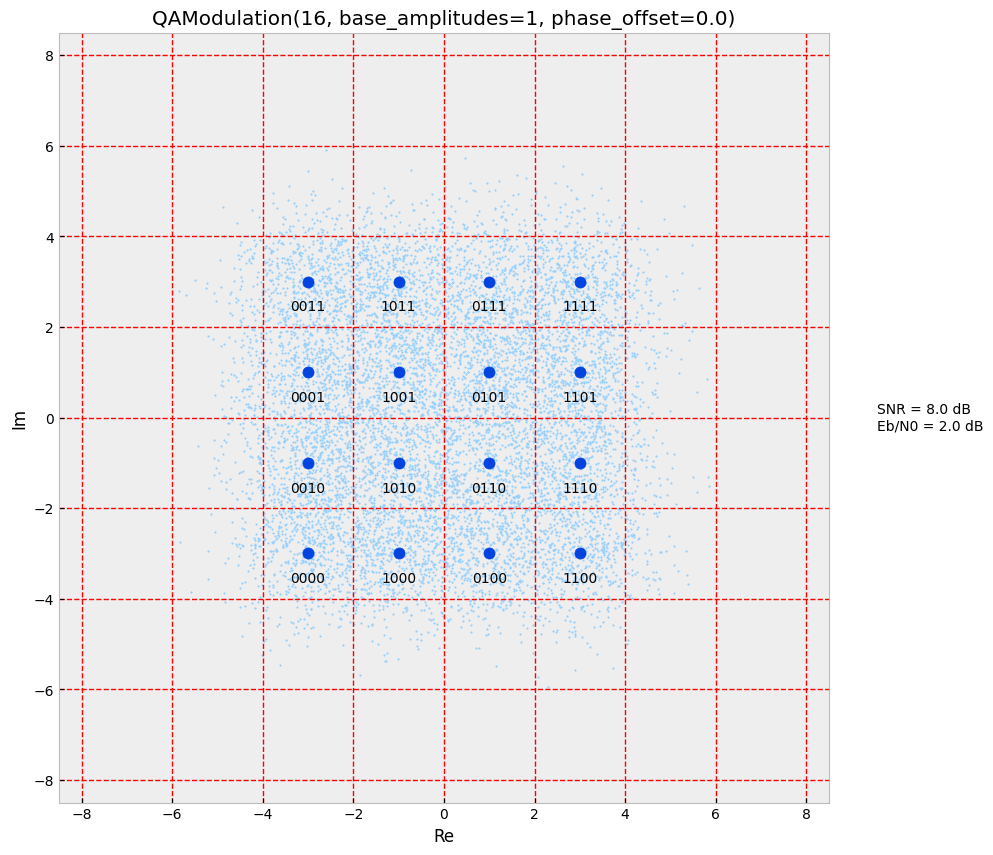

In [68]:
#To get the static figure for saving as pdf
order = 16
base_amplitude=1
phase_offset=0
labeling='natural'
noise_power_db=2

qam_modulation = komm.QAModulation(order, base_amplitude, phase_offset, labeling)
lim = [-2.125*np.sqrt(order), 2.125*np.sqrt(order)]
constellation_demo(qam_modulation, noise_power_db, xlim=lim, ylim=lim)

## Error probabilities

- Averages and we assume equal prior probabilities. 
- *Symbol error probability:* Depends on energy per bit, SNR and decision rule (eq. 6.67):

$$P_\mathrm{e} \approx \bar{N}_{d_\mathrm{min}} Q\left(  \sqrt{\dfrac{\eta_\mathrm{P} E_\mathrm{b}}{2N_0}}   \right),$$

where $\eta_\mathrm{P} = \dfrac{d_\mathrm{min}^2}{E_\mathrm{b}}$.


- *Bit error probability:* Depends on the specific symbol error and *coding* (eq. 6.76):

$$P_\mathrm{bit} \approx Q\left(  \sqrt{\dfrac{\eta_\mathrm{P} E_\mathrm{b}}{2N_0}}  \right).$$

Exact calculation usually hard, many approximations (refer to the book)

### For the 16-QAM

- $d_\mathrm{min} = 2$ (in the case considered before)


- $\bar{N}_{d_\mathrm{min}} = \dfrac{4 \cdot 4 + 4 \cdot 2 + 8 \cdot 3}{16} = 3$

- Energy per symbol = average energy in Q + average energy in I: $E_\mathrm{s} = 2 \cdot (0.5 \cdot 1^2 + 0.5  \cdot 3^2) = 10$


- Energy per bit: $E_\mathrm{b} = \dfrac{E_\mathrm{s}}{\log_2M} = 2.5$

- $\eta_\mathrm{P} = \dfrac{d_\mathrm{min}^2}{E_\mathrm{b}} = \dfrac{2^2}{2.5} = 1.6$

- $P_\mathrm{e} \approx \bar{N}_{d_\mathrm{min}} Q\left( \sqrt{\dfrac{\eta_\mathrm{P} E_\mathrm{b}}{2N_0}} \right) = 3 Q\left( \sqrt{\dfrac{1.6 E_\mathrm{b}}{2N_0}} \right) = 3 Q\left(\sqrt{ \dfrac{4 E_\mathrm{b}}{5N_0} }\right) $

- $P_\mathrm{bit} = Q\left(\sqrt{ \dfrac{4 E_\mathrm{b}}{5N_0} }\right)$

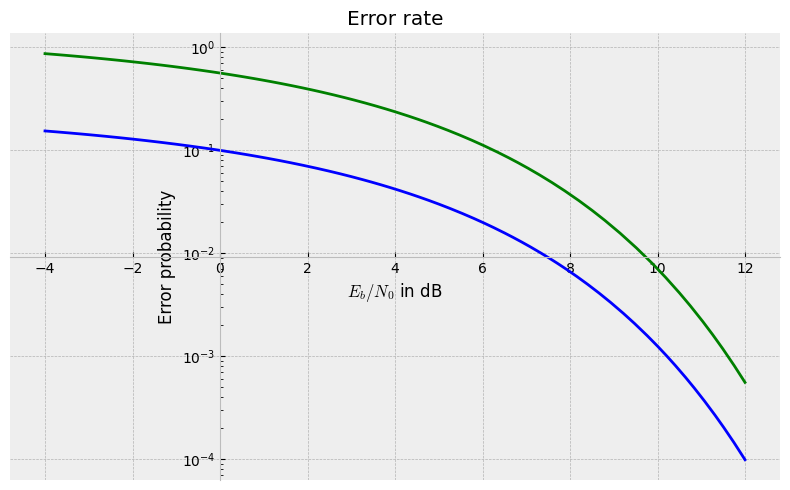

In [69]:
plt.rcParams['figure.figsize'] = 8, 5
plot_aux = sp.plot(sp.N(3*Q(sp.sqrt( 4/5 * 10**(y/10)))), 16/30 * sp.N(Q(sp.sqrt( 4/5 * 10**(y/10)))),(y,-4,12),xlabel='$E_b/N_0$ in dB',
        ylabel='Error probability', yscale= 'log', title='Error rate',show=False);
plot_aux[0].line_color = 'g'
plot_aux[1].line_color = 'b'
plot_aux.show()